In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from glob import glob
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from sklearn.metrics import jaccard_score, accuracy_score
import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Define paths for Kaggle
DATASET_DIR = '/kaggle/input/deepglobe-land-cover-classification-dataset/train'
MASK_CSV = '/kaggle/input/deepglobe-land-cover-classification-dataset/class_dict.csv'

In [3]:
# Load class mapping
class_df = pd.read_csv(MASK_CSV)
class_rgb_values = class_df[['r', 'g', 'b']].values.tolist()
class_names = class_df['name'].tolist()
n_classes = len(class_names)

In [4]:
# Load image and mask paths
image_paths = sorted(glob(os.path.join(DATASET_DIR, '*_sat.jpg')))
mask_paths = sorted(glob(os.path.join(DATASET_DIR, '*_mask.png')))

In [5]:
# Split into training and validation sets
train_size = int(0.8 * len(image_paths))
val_size = len(image_paths) - train_size
train_image_paths, val_image_paths = image_paths[:train_size], image_paths[train_size:]
train_mask_paths, val_mask_paths = mask_paths[:train_size], mask_paths[train_size:]

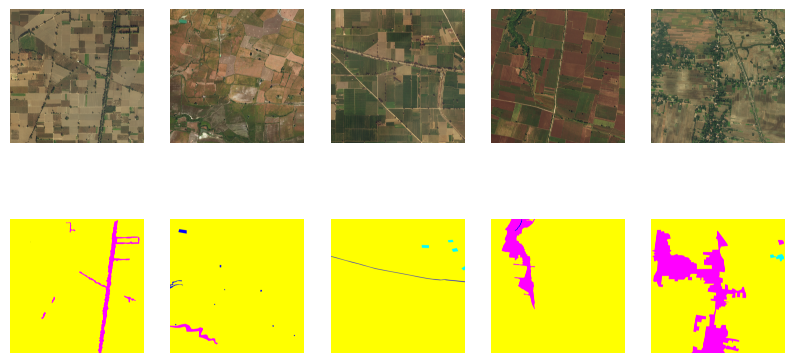

In [6]:
# Visualize some sample images and masks
def visualize_samples(image_paths, mask_paths, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        image = cv2.imread(image_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_paths[i])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(mask)
        plt.axis('off')
    plt.show()

visualize_samples(train_image_paths, train_mask_paths)

In [7]:
# Define dataset and transformations
transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [8]:
# Custom dataset class
class DeepGlobeDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        # Convert RGB mask to class indices
        mask_class = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
        for i, rgb in enumerate(class_rgb_values):
            mask_class[np.all(mask == rgb, axis=-1)] = i
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask_class)
            image = transformed['image']
            mask_class = transformed['mask'].long()
        
        return image, mask_class

In [9]:
# Create datasets and dataloaders
train_dataset = DeepGlobeDataset(train_image_paths, train_mask_paths, transform=transform)
val_dataset = DeepGlobeDataset(val_image_paths, val_mask_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [10]:
# Load pretrained Segformer-B3 model
model = SegformerForSemanticSegmentation.from_pretrained(
    'nvidia/segformer-b3-finetuned-ade-512-512',
    num_labels=n_classes,
    ignore_mismatched_sizes=True
)
model.to('cuda')

config.json:   0%|          | 0.00/6.89k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/190M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b3-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([7, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [11]:
# Define loss function (Dice + CrossEntropy)
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.softmax(pred, dim=1)
    target_one_hot = nn.functional.one_hot(target.long(), n_classes).permute(0, 3, 1, 2).float()
    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

criterion = lambda pred, target: nn.CrossEntropyLoss()(pred, target.long()) + dice_loss(pred, target)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [12]:
# Training loop with validation and early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20, patience=3):
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for images, masks in train_loader:
            images, masks = images.to('cuda'), masks.to('cuda')
            optimizer.zero_grad()
            outputs = model(pixel_values=images).logits
            outputs = nn.functional.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")
        
        # Early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience_counter = 0
            torch.save(model.state_dict(), '/kaggle/working/DeepGlobe_segformerB3_model.pth')
            print("Model saved!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

In [13]:
# Training model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

Epoch 1/20, Loss: 1.9788
Model saved!
Epoch 2/20, Loss: 1.4854
Model saved!
Epoch 3/20, Loss: 1.2938
Model saved!
Epoch 4/20, Loss: 1.2037
Model saved!
Epoch 5/20, Loss: 1.1598
Model saved!
Epoch 6/20, Loss: 1.0804
Model saved!
Epoch 7/20, Loss: 1.0440
Model saved!
Epoch 8/20, Loss: 1.0249
Model saved!
Epoch 9/20, Loss: 0.9914
Model saved!
Epoch 10/20, Loss: 0.9878
Model saved!
Epoch 11/20, Loss: 0.9690
Model saved!
Epoch 12/20, Loss: 0.9528
Model saved!
Epoch 13/20, Loss: 0.9429
Model saved!
Epoch 14/20, Loss: 0.9575
Epoch 15/20, Loss: 0.9484
Epoch 16/20, Loss: 0.9090
Model saved!
Epoch 17/20, Loss: 0.9065
Model saved!
Epoch 18/20, Loss: 0.9008
Model saved!
Epoch 19/20, Loss: 0.9054
Epoch 20/20, Loss: 0.8948
Model saved!


In [14]:
import matplotlib.pyplot as plt

def visualize_predictions(model, val_loader, num_images=5):
    model.eval()
    images, masks = next(iter(val_loader))
    images = images.to('cuda')
    
    with torch.no_grad():
        outputs = model(pixel_values=images).logits
        outputs = torch.argmax(outputs, dim=1).cpu().numpy()
    
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, num_images, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title("Input Image")

        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(masks[i].cpu().numpy())
        plt.axis('off')
        plt.title("Ground Truth Mask")

        plt.subplot(3, num_images, i + 1 + 2*num_images)
        plt.imshow(outputs[i])
        plt.axis('off')
        plt.title("Predicted Mask")
    
    plt.show()


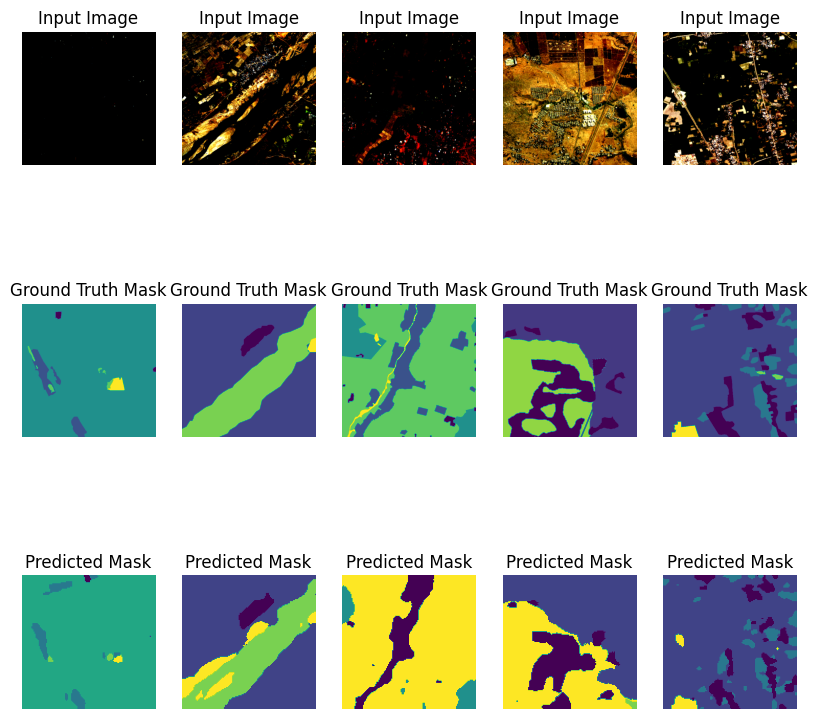

In [15]:
# Visualize predictions
visualize_predictions(model, val_loader)

In [16]:
from sklearn.metrics import jaccard_score, accuracy_score

def calculate_metrics(model, val_loader, num_classes=n_classes):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to('cuda')
            masks = masks.cpu().numpy().reshape(-1)  # Flatten masks correctly

            outputs = model(pixel_values=images).logits
            outputs = torch.argmax(outputs, dim=1).cpu().numpy().reshape(-1)  # Flatten predictions

            all_preds.extend(outputs)
            all_targets.extend(masks)

    # Ensure both lists are of the same length
    if len(all_preds) != len(all_targets):
        min_length = min(len(all_preds), len(all_targets))
        all_preds = all_preds[:min_length]
        all_targets = all_targets[:min_length]

    # Compute Mean IoU and Accuracy
    mean_iou = jaccard_score(all_targets, all_preds, average='macro', labels=list(range(num_classes)))
    accuracy = accuracy_score(all_targets, all_preds)

    print(f"Mean IoU: {mean_iou:.4f}, Accuracy: {accuracy:.4f}")


In [17]:
# Compute and print metrics
calculate_metrics(model, val_loader)

Mean IoU: 0.0883, Accuracy: 0.3784
